In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

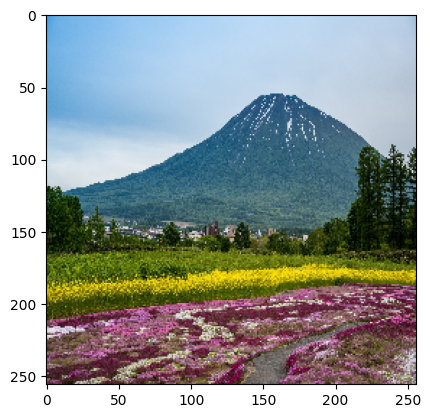

(3, 256, 256)

In [2]:
image = cv2.imread('/Users/akhildevarashetti/code/vision_lab/vision_lab/generation/diffusion/image.jpg')
image = cv2.resize(image, (256, 256))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.transpose(image, (2, 0, 1))
image = image.astype(np.float32) / 255.0
# image = image - 0.5

def imshow(image):
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.show()

imshow(image)
image.shape

# Forward Process

In the forward process,

- We define number of steps T.
-

In [3]:
T = 11

ts = np.linspace(1, T, T).astype(int)
b = np.linspace(0, 1, T)
a = 1 - b
a_bar = np.cumprod(a)
assert len(ts) == len(a) == T

forward_chain = []
labels = []
errors = []
magnitudes = []
image_t = image.copy()
for t in ts:
    noise = np.random.randn(*image.shape).astype(np.float32)
    image_t_prev = image_t.copy()
    image_t_next = a[t-1] * image_t_prev + b[t-1] * noise
    image_t = image_t_next.copy()
    # label_t = 1/a[t-1] * (image_t_next - b[t-1] * noise)

    labels.append(noise)
    forward_chain.append(image_t.copy())
    magnitudes.append(np.mean(image_t))
    errors.append(np.mean((image - image_t) ** 2))

In [4]:
# Backward process
noisy_image = labels[T-1]
for t in reversed(ts[1:]):  # T to 2
    noise = labels[t-1]  # This comes from the model.
    if t == T:
        # impossible as it lost all image information.
        noisy_image = forward_chain[T-2]
    else:
        noisy_image = 1/a[t-1] * (noisy_image - b[t-1] * noise)

    error = np.mean((forward_chain[t-2] - noisy_image) ** 2)
    print(f"{t}: {error}")
error = np.mean((image - noisy_image) ** 2)
print(f"denoised error: {error}")

11: 0.0
10: 1.8898226109043027e-31
9: 4.770267527656509e-30
8: 5.302511174336614e-29
7: 3.3142259945745695e-28
6: 1.3256964184221557e-27
5: 3.6824855694207434e-27
4: 7.515277230517727e-27
3: 1.1742611479009262e-26
2: 1.4497095827914543e-26
denoised error: 1.4497095827914543e-26


/var/folders/qz/8lxmcg3s6ls7rqr51bjgj4080000gp/T/ipykernel_78096/364355134.py:14: RuntimeWarning: invalid value encountered in scalar divide
  image_t_prev = a_bar[t-1] / a[t-1] * image + (1 - a_bar[t-1] / a[t-1]) * noise1


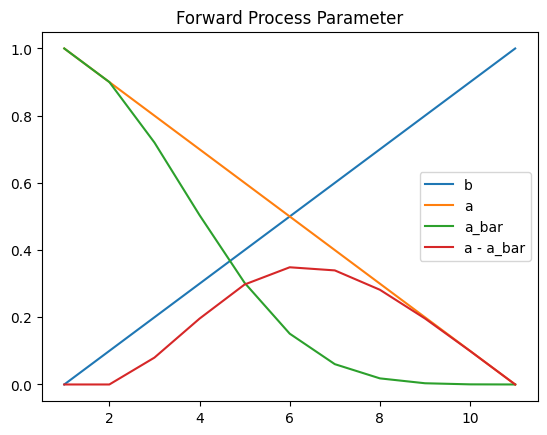

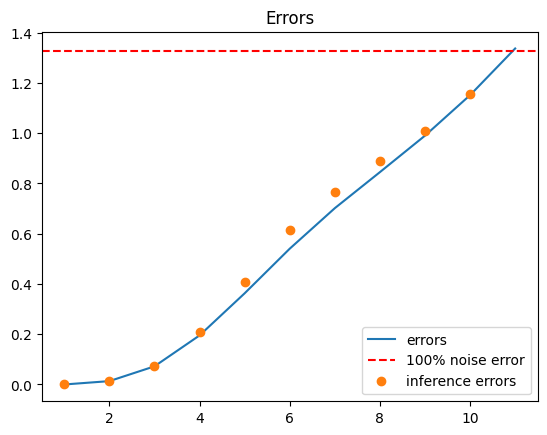

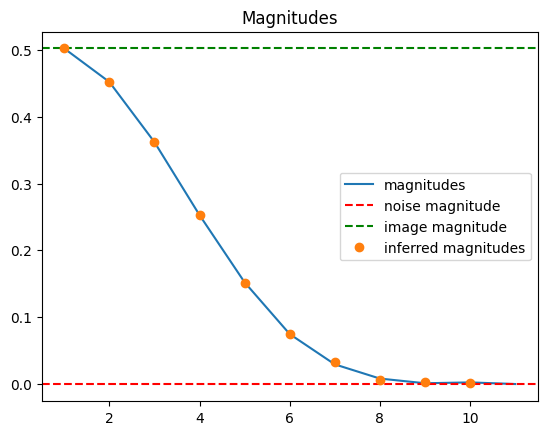

In [5]:
noise_reference = np.random.randn(*image.shape).astype(np.float32)
errors_reference = np.mean((image - noise_reference) ** 2)
magnitude_noise = np.mean(noise_reference)
magnitude_image = np.mean(image)

# Single step trick.
random_ts = ts  # np.random.randint(1, T, 5)
random_errors = []
random_magnitudes = []
for t in random_ts:
    noise1 = np.random.randn(*image.shape).astype(np.float32)
    noise2 = np.random.randn(*image.shape).astype(np.float32)
    # image_t_prev = a_bar[t-2] * image + (1 - a_bar[t-2]) * noise1
    image_t_prev = a_bar[t-1] / a[t-1] * image + (1 - a_bar[t-1] / a[t-1]) * noise1
    image_t = a[t-1] * image_t_prev + b[t-1] * noise2
    # image_t = a_bar[t-1] * image + (a[t-1] - a_bar[t-1]) * noise1 + (1 - a[t-1]) * noise2
    random_magnitudes.append(np.mean(image_t))
    random_errors.append(np.mean((image - image_t) ** 2))

plt.title("Forward Process Parameter")
plt.plot(ts, b, label='b')
plt.plot(ts, a, label='a')
plt.plot(ts, a_bar, label='a_bar')
plt.plot(ts, a - a_bar, label='a - a_bar')
plt.legend()
plt.show()

plt.title("Errors")
plt.plot(ts, errors, label='errors')
plt.axhline(errors_reference, color='r', linestyle='--', label='100% noise error')
plt.plot(random_ts, random_errors, 'o', label='inference errors')
plt.legend()
plt.show()

plt.title("Magnitudes")
plt.plot(ts, magnitudes, label='magnitudes')
plt.axhline(magnitude_noise, color='r', linestyle='--', label='noise magnitude')
plt.axhline(magnitude_image, color='g', linestyle='--', label='image magnitude')
plt.plot(random_ts, random_magnitudes, 'o', label='inferred magnitudes')
plt.legend()
plt.show()

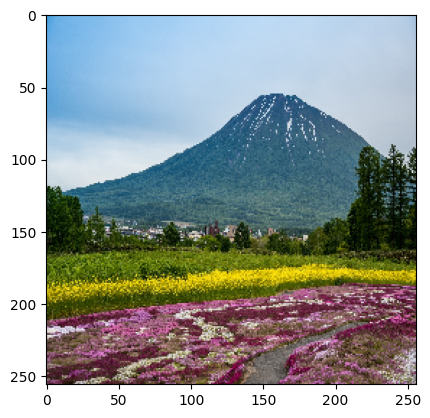

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4316862719058994..1.884977275371552].


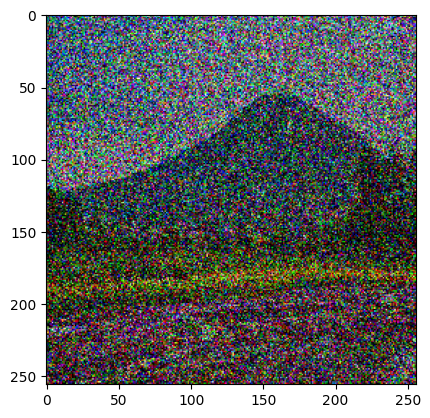

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.826174966263771..2.330097840118408].


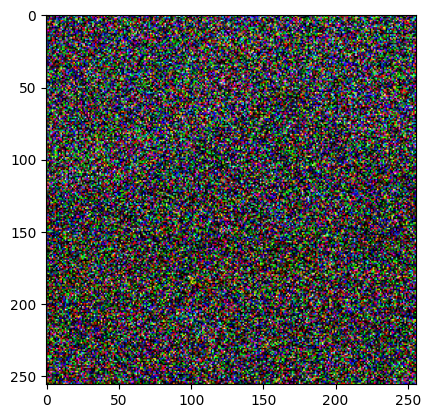

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.450974941253662..4.703479766845703].


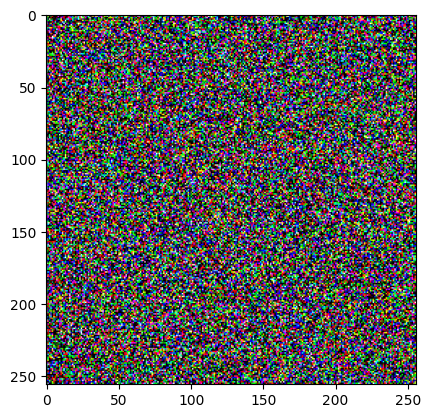

In [6]:
imshow(forward_chain[0])
imshow(forward_chain[3])
imshow(forward_chain[5])
imshow(forward_chain[-1])

```txt
t = 1: x(1) * im + y(1) * no = (1.0 * im + 0.0 * no) = a1 * im + b1 * no

t = 2: x(2) * im + y(2) * no = (0.9 * (1.0*im+0.0*no) + 0.1 * no)
    = a2 * (a1 * im + b1 * no) + b2 * no
    = a1 * a2 * im + a2 * b1 * no + b2 * no
    = (a1 * a2) * im + (a2 * b1 + b2) * no  # b = 1 - a
    = (a1 * a2) * im + (a2 * (1-a1) + (1-a2)) * no
    = (a1 * a2) * im + (a2 - (a1 * a2) + 1 - a2) * no
    = (a1 * a2) * im + (1 - (a1 * a2)) * no  # a_bar2 = a1 * a2
    = a_bar2 * im + (1 - a_bar2) * no

x(t) = a_bar(t)
y(t) = 1 - a_bar(t)

t = 3: x(3) * im + y(3) * no = (0.8 * (0.9*(1.0*im+0.0*no)+0.1*no) + 0.2 * no)
t = 4: x(4) * im + y(4) * no = (0.7 * (0.8*(0.9*(1.0*im+0.0*no)+0.1*no)+0.2*no) + 0.3 * no)
t = 5: x(5) * im + y(5) * no = (0.6 * (0.7*(0.8*(0.9*(1.0*im+0.0*no)+0.1*no)+0.2*no)+0.3*no) + 0.4 * no)
...
t = T: x(T) * im + y(T) * no =


---

t = 1: x(1) * im + y(1) * no + e(1) = (1.0 * im + 0.0 * no1) = a1 * im + b1 * no1
t = 2: a2 * (a1*im + b1*no1) + b2 * no2
    = a1 * a2 * im + b1 * a2 * no1 + b2 * no2  # b = 1 - a
    = (a1 * a2) * im + (1 - a1) * a2 * no1 + (1 - a2) * no2
    = a_bar2 * im + (1  - a2) * no2 + (a2 - a1 * a2) * no1
    = a_bar2 * im + (1  - a2) * no2 + (a2 - a_bar2) * no1

---


x(t) = a * x(t-1) + b * no
a * x(t-1) = x(t) - b * no
x(t-1) = 1/a * (x(t) - b * no)


forward(im, t) -> a_bar(t) * im

```

In [7]:
assert len(forward_chain) == T
t = 2  # 2 to T-1
assert 2 <= t <= T-1
noisy_image = forward_chain[t-1]
target_image = forward_chain[t-2]
label = labels[t-1]

prediction = label
predicted_image = 1/a[t-1] * (noisy_image - b[t-1] * prediction)
error = np.mean((target_image - predicted_image) ** 2)
error

np.float64(4.137455803677784e-33)

In [8]:
# Use the single step trick.
t = 2
assert 2 <= t <= T-1

noise1 = np.random.randn(*image.shape).astype(np.float32)
noise2 = np.random.randn(*image.shape).astype(np.float32)
# target_image = a_bar[t-1] / a[t-1] * image + (1 - a_bar[t-1] / a[t-1]) * noise1
target_image = a_bar[t-2] * image + (1 - a_bar[t-2]) * noise1
input_image = a[t-1] * target_image + b[t-1] * noise2

prediction = noise2
predicted_image = 1/a[t-1] * (input_image - b[t-1] * prediction)

print(np.mean((target_image - predicted_image) ** 2))
if t == 2:
    print(np.mean((target_image - image) ** 2))

4.1313760183256364e-33
0.0
